In [36]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

Вводные

Водитель может находиться в 4 возможных статусах:
    * free -- доступен для нового заказа
    * enroute -- едет на заказ
    * ontrip -- выполняет заказ
    * busy -- недоступен для нового заказа

Возможные переходы из одного состояние в другое определены как:
    * free -> [free, enroute, busy]
    * enroute -> [free, ontrip]
    * ontrip -> [free]
    * busy -> [free]

Почему переходы определяются таким образом:
1. Из состояния free можно перейти в
    * free -- если водитель ушел в офлайн и заново вышел на линию, тогда подряд будет две записи со статусом free
    * enroute -- если водитель принял заказ, то переходит в статус enroute и едет к клиенту
    * busy -- если водитель нажал кнопку "Занят" в таксометре (пошел на обед и т.д.)
2. Из состояния enroute можно перейти в 
    * free -- если клиент или водитель отменил заказ
    * ontrip -- если водитель приехал к клиенту и начал выполнять заказ
3. Из состояния ontrip можно перейти только в free (после выполнения заказа)
4. Из состояния busy можно перейти только в free

Эффективность на поездке -- это время с клиентом в машине (ontrip), деленное на сумму длительностей всех статусов, связанных с поездкой (sum(free) + enroute + ontrip), где sum(free) -- время простоя.

Время простоя -- это сумма всех статусов free, предшествующих поездке. Суммируются все статусы free, идущие подряд, а также те, которые были прерваны короткими статусами busy или enroute (короткий статус == меньше какого-то TIMEOUT'а).

Имеется набор данных со статусами водителей, по которому необходимо построить зависимость длительности поездки от эффективности.
    * driver_id -- id водителя
    * status -- один из статусов
    * dttm -- время начала статуса

Примечания:
    * Поездка считается только при наличии статуса ontrip
    * Тесты написаны для python 2

    1. Написать функцию-генератор, которая будет отдавать соседние элементы в цикле. Функция понадобится для итерирования по записям водителя и проверки соседних статусов по условиям. Не забудьте проверить, что тесты проходят без ошибок (см. test_neighbors).

In [2]:
def neighbors(iterable):
    n = len(iterable)
    
    if n < 1:
        yield (None, None, None)
    elif n == 1:
        yield (None, iterable[0], None)
    else:
        yield (None, iterable[0], iterable[1])
        
        for i in range(2, n):
            yield (iterable[i - 2], iterable[i - 1], iterable[i])
            
        yield (iterable[-2], iterable[-1], None)
    # Write generator function which yields 
    # previous, current and next values in iterable list.
    # ... type your code here ...

In [3]:
# Check if test passes
def test_neighbors():
    test_neighbors = neighbors( range(3) )
#     assert test_neighbors.next() == (None, 0, 1)
    assert next(test_neighbors) == (None, 0, 1)
    assert next(test_neighbors) == (0, 1, 2)
    assert next(test_neighbors) == (1, 2, None)

test_neighbors()

    2. Сгруппировать данные на уровне водителя таким образом, чтобы в одной строке находились все его записи со статусами и началом статуса списком:

Формат исходной таблицы:
<table>
<tr><td>driver_id</td><td>status</td><td>dttm</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>free</td><td>2018-02-04 00:19</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>busy</td><td>2018-02-04 01:03</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>free</td><td>2018-02-03 15:43</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>enroute</td><td>2018-02-03 17:02</td></tr>
<tr><td>...</td><td>...</td><td>...</td></tr>
</table>

Формат сгруппированной таблицы:
<table>
<tr><td>driver_id</td><td>driver_info</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>[("free", 2018-02-04 00:19), ("busy", 2018-02-04 01:03)]</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>[("free", 2018-02-03 15:43), ("enroute", 2018-02-03 17:02) ...]</td></tr>
</table>

In [4]:
df = pd.read_csv("./dataset.csv", parse_dates=["dttm"])
grouped = df.groupby(['driver_id'])
new_data = []
for gr in grouped:
    label = gr[0]
    data = list(zip(gr[1]['status'].values, gr[1]['dttm'].values))
    new_data.append([label, data])

new_df = pd.DataFrame(new_data)
new_df.columns = ['driver_id', 'driver_info']
new_df.head()

,driver_id,driver_info
0,029e9b80b45c483fbb00c4695c2d9c09,"[(free, 2018-02-18T20:01:18.620339000), (enrou..."
1,041ddc65a16649129eb6dbee9b54d6e8,"[(free, 2018-02-18T19:56:21.620339000), (busy,..."
2,048459e02e63450d9429ceb34601929d,"[(free, 2018-02-18T19:49:55.620339000), (enrou..."
3,0f8eccff510f4bdabbff9f40b2262517,"[(free, 2018-02-18T21:02:40.620339000), (busy,..."
4,14637bc848b24ac49fbadc43d207e375,"[(free, 2018-02-18T20:36:13.620339000), (enrou..."


    3. Используя функцию neighbors, написать функцию, которая для каждой записи в списке driver_info посчитает ее длительность.

In [7]:
def calc_status_duration(driver_info):
    driver_info_updated = []
    for i, j, k in neighbors(driver_info):
        if k is None: 
            delta = None
        else:
            delta = (k[1] - j[1]).item()
#             delta = (k[1] - j[1]).total_seconds() for test
        driver_info_updated.append(j + (delta, ))
    return driver_info_updated

In [6]:
# Check if test passes
def test_calc_status_duration():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19)), 
                          ("busy", datetime(2018, 4, 2, 1, 3)),]
    sample_driver_info_updated = [('free', datetime(2018, 4, 2, 0, 19), 2640.0),
                                  ('busy', datetime(2018, 4, 2, 1, 3), None),]
    print(calc_status_duration(sample_driver_info))
    assert calc_status_duration(sample_driver_info) == sample_driver_info_updated

test_calc_status_duration()

[('free', datetime.datetime(2018, 4, 2, 0, 19), 2640.0), ('busy', datetime.datetime(2018, 4, 2, 1, 3), None)]


In [8]:
new_df['driver_info'] = new_df.driver_info.apply(calc_status_duration)

In [9]:
new_df.head()

,driver_id,driver_info
0,029e9b80b45c483fbb00c4695c2d9c09,"[(free, 2018-02-18T20:01:18.620339000, 2499000..."
1,041ddc65a16649129eb6dbee9b54d6e8,"[(free, 2018-02-18T19:56:21.620339000, 2862000..."
2,048459e02e63450d9429ceb34601929d,"[(free, 2018-02-18T19:49:55.620339000, 1233000..."
3,0f8eccff510f4bdabbff9f40b2262517,"[(free, 2018-02-18T21:02:40.620339000, 1574000..."
4,14637bc848b24ac49fbadc43d207e375,"[(free, 2018-02-18T20:36:13.620339000, 1271000..."


    4. Используя функцию neighbors, написать функцию, которая сформирует из списка driver_info список поездок с информацией о длительности поездки и эффективности (duration_ontrip, efficiency).

In [10]:
TIMEOUT = 1600

def collapse_statuses(driver_info):
    driver_info_efficiency = []
    free = 0.
    for i, j, k in neighbors(driver_info):
        if j[2] is None: continue
        if j[0] == 'ontrip':
            driver_info_efficiency.append((j[2], j[2] / (j[2] + i[2] + free)))
        if j[0] == 'free':
            free += j[2]
        else:
            if j[2] > TIMEOUT:
                free = 0.
    return driver_info_efficiency
    # Here define conditions under which the "free" state 
    # should be attributed to the trip.
    # ... type your code here ...

In [11]:
# Check if test passes
def test_collapse_statuses():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19), 2640.0), 
                          ("busy", datetime(2018, 4, 2, 1, 3), 1660.0),
                          ("free", datetime(2018, 4, 2, 1, 30, 40), 2050.0),
                          ("enroute", datetime(2018, 4, 2, 2, 4, 50), 70.0),
                          ("free", datetime(2018, 4, 2, 2, 6), 500.0),
                          ("enroute", datetime(2018, 4, 2, 2, 14, 20), 520.0),
                          ("ontrip", datetime(2018, 4, 2, 2, 23), 3060.0),
                          ("free", datetime(2018, 4, 2, 3, 14), None)
                         ]
    sample_driver_info_updated = [(3060.0, 3060.0 / (3060.0 + 520.0 + 500.0 + 2050.0))]
    print(sample_driver_info_updated)
    print(collapse_statuses(sample_driver_info))
    assert collapse_statuses(sample_driver_info) == sample_driver_info_updated

test_collapse_statuses()

[(3060.0, 0.499184339314845)]
[(3060.0, 0.499184339314845)]


In [12]:
new_df["driver_info"] = new_df.driver_info.apply(collapse_statuses)

    5. Нарисовать и проинтерпретировать зависимость между длительностью поездки и эффективностью.
    Подсказка: требуется сделать обратное преобразование из таблицы со строками на уровне водителя в таблицу со строками на уровне поездки.

In [13]:
trip_time, trip_efficiency = zip(*new_df['driver_info'].sum())
trip_time = np.array(trip_time)
trip_time_norm = trip_time / trip_time.std()
trip_efficiency = np.array(trip_efficiency)

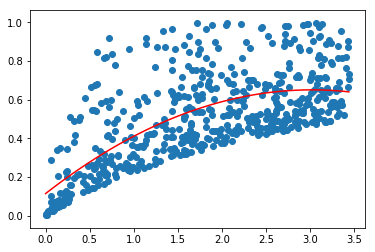

In [28]:
plt.scatter(trip_time_norm, trip_efficiency)
poly = np.polyfit(trip_time_norm, trip_efficiency, 2)

x = np.linspace(0, trip_time_norm.max(), 100)
y = np.polyval(poly, x)
plt.plot(x, y, c='r')

In [25]:
eff_data = pd.DataFrame(np.concatenate((trip_time_norm.reshape(-1, 1), trip_efficiency.reshape(-1, 1)), axis=1))

In [32]:
corr_sp = eff_data.corr('spearman').iloc[1, 0]

In [34]:
print('spearman correlation is {:.2f}'.format(corr_sp))

spearman correlation is 0.64


In [44]:
t_stat = corr_sp * np.sqrt(len(trip_efficiency) - 2) / np.sqrt(1 - corr_sp ** 2)
print(t_stat)
t = scipy.stats.t(len(trip_efficiency) - 2)
p_value = 2 * (1 - t.cdf(np.abs(t_stat)))
print('p_value для нулевой гипотезы: монотонная зависимость между параметрами отсутствует равна {}'.format(p_value))

19.32762006010748
p_value для нулевой гипотезы: монотонная зависимость между параметрами отсутствует равна 0.0


Эффективность поездки зависит от её продолжительности. Хорошо видно ограничение облака точек снизу. Корреляция Спирмена равна 0.64. При этом гипотезу об отсутствии связи между параметрами можно отвергунть на уровне значимости 0.05.